Alunos: Igor Joaquim da Silva Costa e Henrique Daniel de Sousa

# Problema Abordado

O problema "Image-to-Text" refere-se à conversão de uma imagem em uma descrição textual que capture as nuâncias de uma figura. Por muitos anos, computadores foram incapazes de produzir sentidos a partir de imagens coloridas. Com o advento de técnicas mais avançadas de IA, isso mudou.

Fazendo ponte entre a visão computacional e o processamento de linguagem natural, a tarefa de image-to-text tem o objetivo determinar o conteúdo de uma imagem e expressá-lo em uma forma textual que seja precisa, coerente e compreensível para humanos.

Existem muitas formas de resolver esse problema. A solução desenvolvida nesse trabalho faz o uso de redes CNN e mecanismos de atenção em uma arquitetura encoder-decoder para a geração do texto. O modelos foi treinados em um conjunto de dados contendo pares de imagens e suas descrições correspondentes.

![Exemplo do dataset](https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png)

In [ ]:
!pip install -q torchsummary

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import textwrap as wrap
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchsummary import summary

In [ ]:
from collections import Counter
import re
from nltk.tokenize import word_tokenize
import nltk
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# Conjunto de Dados

O dataset utilizado foi o flickr8k, que contém 8000 imagens, cada uma pareada com cinco diferentes descrições. Antes de implementar qualquer modelo, precisamos de uma maneira de lidar com esses dados.

Esta é uma implementação do Dataset, projetada para carregar e processar um conjunto de dados de imagens e suas legendas associadas. Todos as imagens são carregadas para a memória principal no início da execução para aumentar a eficiência.


### Tokenização

Para o preprocessamento das descrições, o texto é convertida para letras minúsculas e são removidos todos os caracteres especiais, como pontuações e símbolos, preservando apenas letras, números e espaços, uniformizando a forma do texto e simplificando o vocabulário.

São adicionados tokens especiais de início $<START>$ e fim $<END>$, além de tokens $<UNK>$ para palavras desconhecidas e $<PAD>$ para padding.

Um vocabulário é criado a partir de todos tokens, atribuindo um índice único a cada palavra. Cada legenda é convertida em uma sequência de IDs correspondentes aos índices das palavras no vocabulário.

Ao fim, o vocabulário se extende por 8831 tokens distintos.

In [ ]:
class FlickrDataset(Dataset):
    '''
    Classe que implementa o dataset utilizado e armazena os dados que serão usados por todo o código.
    root_dir, caption_file *  são os caminhos dos dados
    transform *  é a função que aplica alguma mudança na imagem, isso é usado para data augmentation
    '''
    def __init__(self, root_dir, caption_file, transform=None, max_len=20, preload_limit=20000):
        self.root_dir = root_dir
        self.data = pd.read_csv(caption_file)
        self.transform = transform
        self.max_len = max_len
        self.preload_limit = preload_limit

        # Preprocessamos o texto e criamos o vocabulário a partir disso
        self.captions = self.data['caption'].apply(self.preprocess_caption)
        self.vocab = self.build_vocab(self.captions)

        # Tokenizamos os textos
        self.data['caption'] = self.captions.apply(self.caption_to_ids)

        # Mapeamos cada descrição com uma imagem
        unique_images = self.data['image'].unique()
        self.image_to_idx = {img: idx for idx, img in enumerate(unique_images)}

        # Carregando as imagens para a memória
        # Transform não é utilizado aqui, e sim no método get item
        print("Loading Images...")
        self.preloaded_images = {}
        for img_file in tqdm(unique_images[:self.preload_limit]):
            img_path = os.path.join(self.root_dir, img_file)
            image = Image.open(img_path).convert("RGB")
            self.preloaded_images[self.image_to_idx[img_file]] = image

    def preprocess_caption(self, caption):
        # Aplica processamento no texto de entrada
        caption = caption.lower()
        caption = re.sub(r'[^a-z0-9\s]', '', caption)
        tokens = word_tokenize(caption)
        tokens = ['<START>'] + tokens + ['<END>']
        return tokens

    def build_vocab(self, captions):
        # Construção do vocabulário a partir das legendas
        all_tokens = [token for caption in captions for token in caption if token not in ['<START>', '<END>']]
        freq = Counter(all_tokens)
        vocab = {token: idx + 1 for idx, (token, _) in enumerate(freq.most_common())}

        # Tokens especiais,ids especiais
        vocab['<PAD>'] = 0
        vocab['<UNK>'] = len(vocab)
        vocab['<START>'] = len(vocab)
        vocab['<END>'] = len(vocab)
        return vocab

    def caption_to_ids(self, caption):
        # Efetua a tokenização dos textos
        ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in caption]
        ids = ids[:self.max_len]
        ids += [self.vocab['<PAD>']] * (self.max_len - len(ids))
        return ids

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        caption = torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)

        # Get the image filename from the dataset
        img_name = self.data.iloc[idx, 0]

        # Map image filename to its unique index
        image_idx = self.image_to_idx.get(img_name, None)
        image = self.preloaded_images[image_idx]
        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'caption': caption}
        return sample

def collate_fn(samples):
    # Importante !!!
    # Como as sentenças tem tamanho variável e cada batch deve ser construído de sentenças de mesmo tamanho
    # essa função aplica padding nos vetores para que eles fiquem padronizados
    images = torch.stack([sample['image'] for sample in samples])
    captions = [sample['caption'] for sample in samples]
    captions = pad_sequence(captions, batch_first=True, padding_value=dataset.vocab['<PAD>'])
    return {'image': images, 'caption': captions}


Nessa implementação foi utilizado um batch size de 128 e uma normalização das imagens.
Essas decisões foram tomadas pelos seguintes motivos:
1) Como a RAM da GPU é um fator limitante, batchs de 128 exemplos balanceiam a estabilidade no treino e a velocidade durante o treinamento. Esse valor foi escolhido empiricamente após vários testes seguidos.

2) A normalização se dá pelo uso da rede pré-treinada de backbone ( veja seção da implementação da rede ) que supõe que as imagens estejam normalizadas.


Também há uma transformação feita em cada imagem, realizando os seguintes processos:

* Redimensiona o lado menor da imagem de entrada para 226 pixels, mantendo a proporção original
* Recorta aleatoriamente uma região quadrada de 224x224 pixels da imagem redimensionada
* Converte a imagem para um tensor e escala os valores dos pixels da faixa [0, 255] para a faixa [0, 1]
* Normaliza a imagem em tensor subtraindo a média e dividindo pelo desvio padrão para cada canal (RGB)



In [ ]:
# Setting the constants
data_location = "../input/flickr8k"
BATCH_SIZE = 128

# Defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# Testing the dataset class
dataset = FlickrDataset(
    root_dir=data_location + "/Images",
    caption_file=data_location + "/captions.txt",
    transform=transforms
)

# Vocabulary size (assuming vocabulary is needed for text processing)
vocab_size = len(dataset.vocab)
print(f'Vocabulary Size: {vocab_size}')

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Loading Images...


100%|██████████| 8091/8091 [01:13<00:00, 110.29it/s]

Vocabulary Size: 8831
Device: cuda


### Exemplos de imagens e descrições

In [ ]:
from torchvision.transforms import ToPILImage, Normalize
# Define the denormalization transform
denormalize = Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [ ]:
import matplotlib.pyplot as plt
from textwrap import wrap

def display_images(dataset):

    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):

        instance = dataset.__getitem__(i*5)
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = denormalize(instance['image'])
        caption = instance['caption']

        reference = [word for token in caption for (word,token_v) in dataset.vocab.items() if token == token_v]
        reference = [token for token in reference if token != '<PAD>']

        # reference = [token for token in reference if token not in ['<START>', '<END>']]

        string_reference = ' '.join(reference)

        plt.imshow(image.permute(1, 2, 0))
        plt.title("\n".join(wrap(string_reference, 20)))
        plt.axis("off")

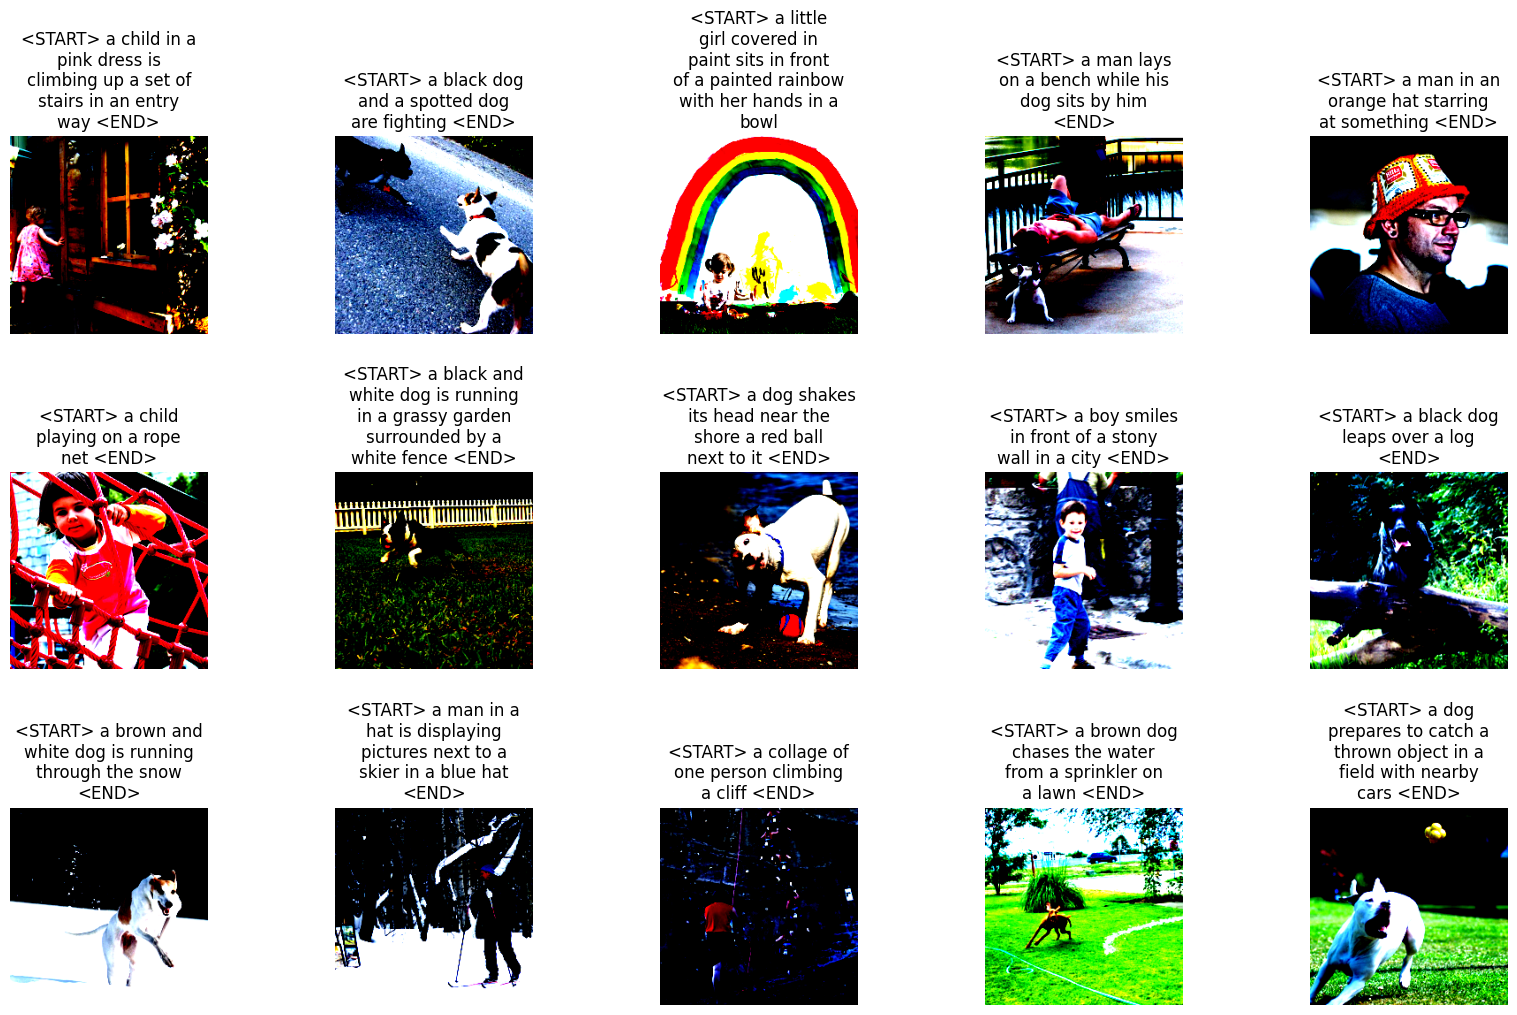

In [ ]:
display_images(dataset)

## Separação treino-teste

Como o conjunto de dados corresponde a 8000 imagens com 5 legendas possíveis, a separação entre os conjuntos de treino, teste e validação deve ser mais cuidadosa. A separação deve ser feita entre as 8000 imagens, e não nos 40000 mil pares imagem-legenda. Isso deve ser feito para evitar data leakage.

Por exemplo, se feito de forma errada, podemos ter a mesma imagem no treino e no teste, porém com legendas ligeiramente diferentes. Situações assim mascaram o poder de generalização do modelo, devendo ser evitadas a todo custo.

Dessa forma, 80% das imagens são para treino, 10% para validação e 10% para teste.

In [ ]:
from sklearn.model_selection import train_test_split

# Considerando apenas o conjunto de imagens (sem repetição), separamos entre treino teste e val
unique_image_indices = np.arange(len(dataset.data["image"].unique()))
train_idx, test_val_idx = train_test_split(unique_image_indices, test_size=0.2, random_state=42, shuffle=True)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
from torch.utils.data import Subset

# A construção dos subsets também deve ter esse cuidado adicional
# Ela funciona ao selecionar todas as instâncias do dataset original
# que possuem imagens especificadas em "image_indices"
# Dessa forma, não existe interseção entre os conjuntos
def create_dataset_subset_from_images(dataset, image_indices):
    # Map image indices to the image filenames
    image_filenames = set(dataset.data["image"].unique()[image_indices])

    # Get dataset indices where the image filenames are in the subset
    data_indices = [i for i in range(len(dataset.data)) if dataset.data.iloc[i, 0] in image_filenames]

    # Create and return the subset
    return Subset(dataset, data_indices)

# Example usage
train_dataset = create_dataset_subset_from_images(dataset, train_idx)
val_dataset = create_dataset_subset_from_images(dataset, val_idx)
test_dataset = create_dataset_subset_from_images(dataset, test_idx)

In [ ]:
# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


# Redes Implementadas

Nessa seção, são descritos os mecanismos e abstrações utilizadas para a construção dos modelos.
De maneira geral, as redes implementadas tentam imitar uma arquitetura de tradução sequência para sequência.

Na formulação original de tradução seq2seq, temos o objetivo de gerar, a partir de uma sentença em uma língua, uma sentença equivalente em outra. Aqui, entretanto, o contexto é diferente. Não temos 2 sequências para trabalhar, sim um par imagem-texto, mas não precisa ser assim.


<img src="https://miro.medium.com/v2/resize:fit:896/1*NO2OpFhjssG82z3sSrsdLQ.jpeg" alt="image.png" width="800"/>


A imagem acima é um exemplo da variedade de elementos (cores distintas) que podem estar presentes em uma imagem. O que pode se notar é que existe uma separação espacial entre esses diferentes elementos. Fazendo uma aproximação grosseira, cada parte da imagem possui algumas informações importantes para a legenda, como a presença de pessoas, a cor dos objetos da cena, qual é o fundo, etc. A ideia é transformar cada uma dessas partes da imagem "palavras" distintas e tentar gerar uma nova sentença a partir disso.  

Usando uma modelagem parecida com os "visual transformers", podemos aproximar ainda mais o cenário e dizer que existe no máximo Z conceitos diferentes em uma imagem. Assim, o trabalho do modelo Encoder é transformar uma imagem de uma matriz (H,W,C) em uma sequência de Z vetores distintos, onde cada vetor modela um conceito distinto.

Com essa sequência em mãos, a tradução pode ser feita. O decoder é responsável por correlacionar os conceitos gerados pelo encoder e gerar novos tokens, a fim de descrever textualmente a imagem.


<img src="https://www.researchgate.net/publication/329464533/figure/fig3/AS:701043021197314@1544153089772/An-attention-based-seq2seq-model.ppm" alt="image.png" width="800"/>

## Encoder


O modelo é projetado para extrair features de imagens utilizando a EfficientNet e refinar essas features usando mecanismos de multihead attention. A combinação de CNNs para extração de features e attention para processamento sequencial permite que o modelo capture informações espaciais e contextuais importantes nas imagens, tornando-o adequado para tarefas como geração de legendas para imagens ou outras tarefas de visão computacional que envolvem sequências de dados.

Mais especificamente, a última camada da EfficientNet gera um objeto em um espaço vetorial de (1028,7,7) dimensões, ou seja, a informação espacial da imagem está toda representada nesse mapa de 7 por 7 blocos (cada bloco é uma região de 32 pixels da imagem original). Com isso, seria possível gerar uma sequência de 49 "palavras", usando a abstração comentada acima. Entretanto, essas "palavras" não possuem tanto valor semântico.

A partir dai, as 1028 informações de filtros são projetadas em um espaço vetorial menor, chamado de embedding, utilizando uma convolução 1x1. Como 49 é um número grande de conceitos para se ter em uma imagem, os blocos são combinados entre si para gerar uma sequência de tamanho 20. Por fim, são utilizadas N camadas de "full attention" concatenadas para gerar o sentido para o texto.

### Encoder Attention

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EncoderAttention(nn.Module):
    def __init__(self, embed_size, seq_len, num_heads=8):
        super(EncoderAttention, self).__init__()

        # Define the Multihead Attention layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, batch_first=True)

        # Define additional normalization layers
        self.layer_norm_after_attention = nn.LayerNorm(embed_size)
        self.layer_norm_after_proj = nn.LayerNorm(embed_size)

        # Define a non-linearity (ReLU)
        self.proj = nn.Linear(embed_size, embed_size)
        self.relu = nn.ReLU()

    def forward(self, features):
        residual = features
        # Apply Multihead Attention
        attention_output, attention_weights = self.multihead_attention(features, features, features)

        # Apply Layer Normalization after adding attention output
        features = self.layer_norm_after_attention(features + attention_output)

        # Apply Projection
        features = self.proj(features)

        # Apply Layer Normalization after projection
        features = self.layer_norm_after_proj(features)

        # Apply non-linearity
        features = self.relu(features + residual)

        return features


O modelo utiliza a EfficientNet pré-treinada como a base convolucional para extrair features ricas das imagens. A EfficientNet é conhecida por sua eficiência e desempenho, tendo sido treinada no ImageNet. As últimas camadas classificadoras da EfficientNet são removidas, deixando apenas as camadas convolucionais que extraem as features.

Todos os parâmetros da **EfficientNet** são congelados, utilizando
```python
param.requires_grad = False
```
Isso significa que eles não serão atualizados durante o treinamento. Isso ajuda a diminuir o tempo de treinamento, evitando que o backpropagation percorra a EfficientNet inteira, mas diminuindo a capacidade do modelo.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    '''
    Modelo Encoder completo, depende da classe EncoderAttention
    Essa camada recebe uma imagem como entrada e uma sequência,
    Ela consiste das camadas
        1) Backbone (efficientnet)
        2) Embedding + Positional Embedding
        3) N attentions em sequência
    '''

    def __init__(self, embed_size, seq_len, num_heads=8, num_layers=1):
        super(EncoderCNN, self).__init__()
        efficientnet = models.efficientnet_b0(weights='DEFAULT')
        modules = list(efficientnet.children())[:-2]  # Remove as últimas layers
        self.efficientnet = nn.Sequential(*modules)

        # Congelando a efficientnet_b0
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        # Defina uma Convolução 1x1 para projetar as features no tamanho do embedding
        self.conv1x1 = nn.Conv2d(1280, embed_size, kernel_size=1)  # EfficientNet-b0 output channels are 1280

        # Defina uma nova fully connected para mapear os blocos em seq_len palavras
        self.fc = nn.Linear(49,seq_len)
        self.bn = nn.BatchNorm1d(seq_len)
        self.seq_len = seq_len

        # Positional embeddings
        self.positional_embeddings = nn.Embedding(seq_len, embed_size)

        # Lista dos mecanismos de atenção
        self.attention_layers = nn.ModuleList([
            EncoderAttention(embed_size, seq_len, num_heads) for _ in range(num_layers)
        ])

        self.embed_size = embed_size

    def forward(self, images):
        batch_size = images.size(0)

        # features da EfficientNet
        features = self.efficientnet(images)  # (batch_size, 1280, 7, 7)

        # 1x1 Convolution para projeção
        features = self.conv1x1(features)  # (batch_size, embed_size, 7, 7)

        # Reordenando os blocos
        features = features.view(batch_size, self.embed_size, -1)  # (batch_size, embed_size, 49)

        # Projetando os 49 blocos em #seq_len blocos
        features = self.fc(features)  # (batch_size, embed_size, seq_len)

        # Reordenando a ordem das dimensões para a camada de atenção
        features = features.permute(0, 2, 1)  # (batch_size, seq_len, embed_size)

        # Criação dos indices para o positional encoding
        positions = torch.arange(0, self.seq_len, device=features.device).unsqueeze(0).expand(batch_size, self.seq_len)

        # Adicionando os embeddings de posição nos blocos
        pos_embeddings = self.positional_embeddings(positions)
        features = features + pos_embeddings

        # N layers de attention
        for attention_layer in self.attention_layers:
            features = attention_layer(features)

        return features

In [ ]:
class EncoderSummaryWrapper(nn.Module):
    def __init__(self, encoder_cnn):
        super(EncoderSummaryWrapper, self).__init__()
        self.conv1x1 = encoder_cnn.conv1x1
        self.fc = encoder_cnn.fc
        self.bn = encoder_cnn.bn
        self.positional_embeddings = encoder_cnn.positional_embeddings
        self.attention_layers = encoder_cnn.attention_layers

    def forward(self, x):
        # Replace this with the input that would come after EfficientNet
        x = torch.randn((x.size(0), 1280, 7, 7), device=x.device)  # Simulate EfficientNet output
        x = self.conv1x1(x)
        x = x.view(x.size(0), -1, 49)
        x = self.fc(x)
        x = x.permute(0, 2, 1)
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0).expand(x.size(0), x.size(1))
        pos_embeddings = self.positional_embeddings(positions)
        x = x + pos_embeddings
        for attention_layer in self.attention_layers:
            x = attention_layer(x)
        return x

# Create the model and the summary wrapper
sample_encoder = EncoderCNN(8*20, 20, num_layers=16).to(device)
summary_wrapper = EncoderSummaryWrapper(sample_encoder).to(device)

# Generate the summary
summary(summary_wrapper, input_size=(1280, 7, 7))  # Input size should match the output of EfficientNet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 160, 7, 7]         204,960
            Linear-2              [-1, 160, 20]           1,000
         Embedding-3              [-1, 20, 160]           3,200
MultiheadAttention-4  [[-1, 20, 160], [-1, 20, 20]]               0
         LayerNorm-5              [-1, 20, 160]             320
            Linear-6              [-1, 20, 160]          25,760
         LayerNorm-7              [-1, 20, 160]             320
              ReLU-8              [-1, 20, 160]               0
  EncoderAttention-9              [-1, 20, 160]               0
MultiheadAttention-10  [[-1, 20, 160], [-1, 20, 20]]               0
        LayerNorm-11              [-1, 20, 160]             320
           Linear-12              [-1, 20, 160]          25,760
        LayerNorm-13              [-1, 20, 160]             320
             ReLU-14          

## Decoder



O **Decoder** é composto por várias camadas de atenção, além de embeddings de palavras e embeddings posicionais, que são usados para gerar a sequência final.

A **entrada** é uma sequência de índices de palavras e as features extraídas pelo codificador. Assim, as entradas são processadas por embeddings de palavras e posicionais, e então refinadas através de múltiplas camadas de attention.
A camada de attention é uma camada que combina *cross-attention* e *self-attention* para processar sequências de dados, como uma sentença em linguagem natural.

Para cada posição na sequência de entrada, o decoder gera uma distribuição de probabilidade sobre o vocabulário, indicando a próxima palavra mais provável a ser gerada.

In [ ]:
import torch
import torch.nn as nn

class AttentionLayer(nn.Module):
    '''
    Modelo de atenção do decoder
    Ela consiste das camadas
        1) Cross-attention + Norm
        2) Self-attention + norm
        3) FeedForward + norm
        4) residual connection
    '''
    def __init__(self, embed_size, num_heads=1):
        super(AttentionLayer, self).__init__()
        self.cross_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=0.1, batch_first=True)
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=0.1, batch_first=True)
        self.fc = nn.Linear(embed_size, embed_size)

        # Layer Norms
        self.layer_norm_after_cross_attention = nn.LayerNorm(embed_size)
        self.layer_norm_after_self_attention = nn.LayerNorm(embed_size)
        self.layer_norm_final = nn.LayerNorm(embed_size)

        # Activation Function
        self.activation = nn.ReLU()

    def forward(self, encoder_out, embeddings):
        seq_len = embeddings.size(1)  # Get the sequence length
        batch_size = embeddings.size(0)  # Get the batch size
        encoder_len = encoder_out.size(1)
        residual = embeddings

        # Primeira aplicação, cross_attention entre a sentença gerada e a imagem
        context, _ = self.cross_attention(key=encoder_out, query=embeddings, value=encoder_out)
        embeddings = embeddings + context
        embeddings = self.layer_norm_after_cross_attention(embeddings)  # Apply Layer Norm after cross-attention

        # Segunda aplicação, self_attention da frase gerada. Mascara usada para evitar data leakage
        mask = torch.tril(torch.ones((seq_len, seq_len), device=embeddings.device), diagonal=0)
        mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        # Em pytorch, valores -inf são ignorados e valores 0 são utilizados na atenção
        context, _ = self.self_attention(key=embeddings, query=embeddings, value=embeddings, attn_mask=mask)
        embeddings = embeddings + context
        embeddings = self.layer_norm_after_self_attention(embeddings)  # Apply Layer Norm after self-attention

        # Apply final Linear layer and activation
        embeddings = self.fc(embeddings)
        embeddings = self.layer_norm_final(embeddings)  # Apply final Layer Norm
        embeddings = self.activation(embeddings + residual)  # Apply non-linearity

        return embeddings


In [ ]:
import torch
import torch.nn as nn

max_len = 20
class Decoder(nn.Module):
    '''
    Modelo decoder
    Ela consiste das camadas
        1) Embedding + Positional Embedding
        2) N camadas de attention
        3) Output FeedForward
    '''
    def __init__(self, embed_size, vocab_size, num_heads=1, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.pos_embed = nn.Embedding(max_len, embed_size)

        self.attention_layers = nn.ModuleList([AttentionLayer(embed_size, num_heads) for _ in range(num_layers)])
        self.fc = nn.Linear(embed_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, encoder_out, captions):
        seq_len = captions.size(1)  # Get the sequence length
        batch_size = captions.size(0)  # Get the batch size

        # Camada de embedding
        embeddings = self.embed(captions.long())   # (batch_size, seq_len,     embed_size)
        features = encoder_out              # (batch_size, encoder_len, embed_size)

        # Camada de positional embeddings
        positions = torch.arange(0, seq_len, device=captions.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_embeddings = self.pos_embed(positions)  # (batch_size, seq_len, embed_size)
        embeddings = embeddings + pos_embeddings    # (batch_size, seq_len, embed_size)

        # N camadas de atenção
        for layer in self.attention_layers:
            embeddings = layer(encoder_out, embeddings)

        # Camada de output
        output = self.fc(embeddings)  # (batch_size, seq_len, vocab_size)

        return output

O treinamento será feito utilizando múltiplas GPUS.

Os modelos são instanciados a baixo

In [ ]:
import torch.optim as optim
# Hyperparameters
vocab_size = len(dataset.vocab)

embed_size = 8*20
num_heads = 8
learning_rate = 3e-4
num_epochs = 25
seq_len = 20
num_layers = 16


# Inicializamos o encoder e o decoder
encoder = EncoderCNN(embed_size,seq_len,num_layers = num_layers).to(device)
decoder = Decoder(embed_size, vocab_size, num_heads = num_heads, num_layers = num_layers).to(device)

num_gpus = torch.cuda.device_count()

if num_gpus > 1:
    print(f'Using {num_gpus} GPUs for training.')
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)

encoder = encoder.to(device)
decoder = decoder.to(device)

Using 2 GPUs for training.


In [ ]:
def custom_summary(model):
    # Print header
    print(f"{'Layer':<55} {'Param #':<15}")
    print("=" * 55)

    # Function to calculate the number of parameters
    def get_param_count(module):
        return sum(p.numel() for p in module.parameters() if p.requires_grad)

    # Iterate through each layer in the model
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d, nn.Embedding, nn.BatchNorm2d, nn.LayerNorm, nn.MultiheadAttention)):
            param_count = get_param_count(module)
            print(f"{name:<55} {param_count:<15}")

    # Print total number of trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("=" * 55)
    print(f"Total Parameters: {total_params:,}")

custom_summary(decoder)

Layer                                                   Param #        
embed                                                   1412960        
pos_embed                                               3200           
attention_layers.0.cross_attention                      103040         
attention_layers.0.cross_attention.out_proj             25760          
attention_layers.0.self_attention                       103040         
attention_layers.0.self_attention.out_proj              25760          
attention_layers.0.fc                                   25760          
attention_layers.0.layer_norm_after_cross_attention     320            
attention_layers.0.layer_norm_after_self_attention      320            
attention_layers.0.layer_norm_final                     320            
attention_layers.1.cross_attention                      103040         
attention_layers.1.cross_attention.out_proj             25760          
attention_layers.1.self_attention                       103040  

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Number of Trainable Parameters: {total_params:,}")

Número de parâmetros treináveis do decoder

In [ ]:
count_parameters(decoder)


Total Number of Trainable Parameters: 6,562,751


Número de parâmetros treináveis do encoder

In [ ]:
count_parameters(encoder)


Total Number of Trainable Parameters: 2,280,240


Dessa forma, o modelo final fica com 8,842,991 parâmetros treináveis.

Embora o decoder tenha consideravelmente mais parâmetros *treináveis*, vale lembrar que o encoder utiliza um modelo pré-treinado de backbone, que faz com que ele seja ainda maior. A rede efficientenet_b0 possui cerca de 5M de parâmetros.

# Treinamento da Rede

 **Loss function: CrossEntropyLoss**

 Esta função é comumente usada para tarefas de classificação multiclasse. Nesse caso, essa loss será utilizada para o modelo prever a classe correta (ou token) para cada entrada.

 **Otimizador: Adam**

 É um otimizador baseado em gradientes com ajuste automático da taxa de aprendizado. O learning rate definido foi de 3e-4

In [ ]:
# Optimizers
criterion = nn.CrossEntropyLoss()
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

In [ ]:
import sys
import time

## Treinamento

A função train_step executa um ciclo de treinamento para uma única época, envolvendo

* Um forward step e cálculo das previsões.
* Cálculo da loss e ajuste de parâmetros por meio do backpropagation.

Essa função ajuda a treinar o modelo ajustando seus parâmetros com base nos dados fornecidos e na loss calculada.

In [ ]:
def train_step(encoder, decoder, train_loader, criterion, optimizer, device, epoch, num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    start_time = time.time()

    for i, sample in enumerate(train_loader):
        images = sample['image'].to(device)
        captions = sample['caption'].to(device)

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions)

        batch_size, seq_len, vocab_size = outputs.size()

        # Mascara para ignorar as posições de padding
        mask = (captions != 0).float()
        # A variável caption é a legenda real da foto
        # Como queremos prever o próximo token a partir do atual, os "targets" é a própria legenda
        # entretanto, ignorando o token de <START>, isso faz com que o modelo preveja o token que está por vir na sequência
        targets = captions[:, 1:].contiguous().view(-1)  # Shift na legenda
        logits = outputs[:, :-1, :].contiguous().view(-1, vocab_size)  # última predição não é utilizada

        # calculo da loss, ignorando o primeiro token (`<START>`)
        loss = criterion(logits, targets)
        # aqui, a mascara serve para ignorar as posições <PAD> do input
        loss = (loss * mask[:, 1:].contiguous().view(-1)).sum() / mask[:, 1:].sum()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Proffiling
        elapsed_time = time.time() - start_time
        avg_loss = total_loss / (i + 1)
        sys.stdout.write(f'\rEpoch [{epoch+1}/{num_epochs}] | '
                         f'Step [{i+1}/{len(train_loader)}] | '
                         f'Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}')
        sys.stdout.flush()

    avg_train_loss = total_loss / len(train_loader)
    print(f'\nEpoch [{epoch+1}/{num_epochs}] | Average Training Loss: {avg_train_loss:.4f}')
    return avg_train_loss

O passo de validação realiza os seguintes procedimentos:

* Avalia o modelo nos dados de validação
* Computa a loss
* Calcula o BLEU score para as descrições geradas, comparando ao ground truth.
* Computa a acurácia baseada na predição dos tokens.

O BLEU (Bilingual Evaluation Understudy) é uma métrica de avaliação utilizada principalmente para medir a qualidade de traduções automáticas. O BLEU compara a precisão das n-gramas (sequências de palavras) entre o texto gerado por um modelo e as legendas verdadeiras. Ele varia em uma escala de 0 a 1, sendo que quanto mais próximo de 1, melhores sao as descrições geradas.

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

def val_step(encoder, decoder, val_loader, criterion, device, epoch, num_epochs):
    encoder.eval()
    decoder.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Lists to store predictions and references for BLEU computation
    all_references = []
    all_candidates = []

    with torch.no_grad():
        for sample in val_loader:
            images = sample['image'].to(device)
            captions = sample['caption'].to(device)

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions)

            batch_size, seq_len, vocab_size = outputs.size()

            mask = (captions != 0).float()
            # A variável caption é a legenda real da foto
            # Como queremos prever o próximo token a partir do atual, os "targets" é a própria legenda
            # entretanto, ignorando o token de <START>, isso faz com que o modelo preveja o token que está por vir na sequência
            targets = captions[:, 1:].contiguous().view(-1)  # Shift captions to match predictions
            logits = outputs[:, :-1, :].contiguous().view(-1, vocab_size)  # Exclude the last prediction

            # Compute loss, ignoring the first token (`<START>`)
            loss = criterion(logits, targets)
            loss = (loss * mask[:, 1:].contiguous().view(-1)).sum() / mask[:, 1:].sum()
            total_loss += loss.item()

            # BLEU score
            preds = outputs.argmax(dim=-1)
            for i in range(preds.size(0)):
                reference = captions[:, 1:][i].cpu().numpy().tolist()
                candidate = preds[i].cpu().numpy().tolist()

                # Comparamos cada frase gerada com a frase original, sem padding
                candidate = [token for token in candidate if token != dataset.vocab['<PAD>']]
                reference = [token for token in reference if token != dataset.vocab['<PAD>']]

                all_references.append([reference])
                all_candidates.append(candidate)

            # Calculo da acurácia também ignora a presença de posições <PAD> e <START>
            correct = ((preds[:, :-1] == captions[:, 1:]) * mask[:, 1:]).float().sum().item()
            total_correct += correct
            total_samples += mask.sum().item()

    # Compute BLEU score using NLTK
    avg_bleu = corpus_bleu(all_references, all_candidates)

    avg_loss = total_loss / len(val_loader)
    accuracy = total_correct / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}] | Average Validation Loss: {avg_loss:.4f} | BLEU Score: {avg_bleu:.4f} | Accuracy: {accuracy:.4f}')

    return avg_loss, avg_bleu, accuracy

In [ ]:
# Initialize variables to track the best validation loss
best_bleu_score = 0.0
best_model_path = 'best_model.pth'

In [ ]:
# Initialize lists to track metrics
train_losses = []
val_losses = []
val_bleu_scores = []
val_accuracies = []

O treinamento foi executado para 25 épocas

In [ ]:
for epoch in range(num_epochs):
    # Training step
    train_loss = train_step(encoder, decoder, train_loader, criterion, optimizer, device,epoch,num_epochs)
    train_losses.append(train_loss)

    # Validation step
    val_loss, val_bleu, val_accuracy = val_step(encoder, decoder, val_loader, criterion, device,epoch,num_epochs)
    val_losses.append(val_loss)
    val_bleu_scores.append(val_bleu)
    val_accuracies.append(val_accuracy)

    # Save the best model based on BLEU score
    if val_bleu > best_bleu_score:
        best_bleu_score = val_bleu
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bleu_score': val_bleu,
        }, best_model_path)
        print(f'New best model saved with BLEU score: {val_bleu:.4f} acc {val_accuracy:.4f}')
    print()

Epoch [1/25] | Step [253/253] | Loss: 3.5957 | Time: 179.24
Epoch [1/25] | Average Training Loss: 3.5957
Epoch [1/25] | Average Validation Loss: 2.8292 | BLEU Score: 0.0213 | Accuracy: 0.2376
New best model saved with BLEU score: 0.0213 acc 0.2376

Epoch [2/25] | Step [253/253] | Loss: 2.6590 | Time: 178.12
Epoch [2/25] | Average Training Loss: 2.6590
Epoch [2/25] | Average Validation Loss: 2.5327 | BLEU Score: 0.0315 | Accuracy: 0.2761
New best model saved with BLEU score: 0.0315 acc 0.2761

Epoch [3/25] | Step [253/253] | Loss: 2.4141 | Time: 179.23
Epoch [3/25] | Average Training Loss: 2.4141
Epoch [3/25] | Average Validation Loss: 2.3634 | BLEU Score: 0.0467 | Accuracy: 0.2982
New best model saved with BLEU score: 0.0467 acc 0.2982

Epoch [4/25] | Step [253/253] | Loss: 2.2567 | Time: 179.15
Epoch [4/25] | Average Training Loss: 2.2567
Epoch [4/25] | Average Validation Loss: 2.2513 | BLEU Score: 0.0577 | Accuracy: 0.3156
New best model saved with BLEU score: 0.0577 acc 0.3156

Epoc

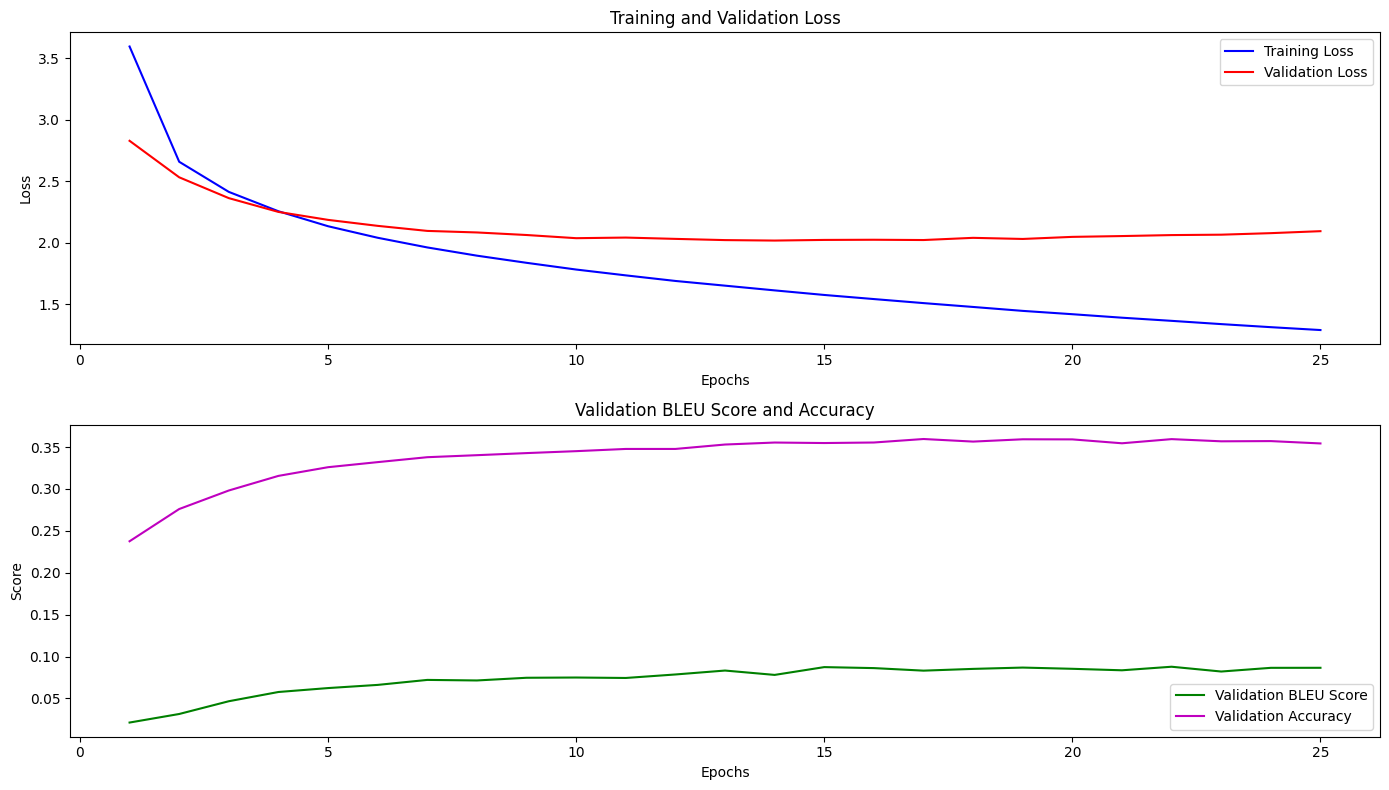

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 8))

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting BLEU score and accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, val_bleu_scores, 'g-', label='Validation BLEU Score')
plt.plot(epochs, val_accuracies, 'm-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation BLEU Score and Accuracy')
plt.legend()

# Adjust the layout
plt.tight_layout()
plt.show()

Do gráfico da loss pelas épocas, é possível ver que houve um overfitting do modelo aos dados de treino. Entretanto, houve um aumento tanto na acurácia quanto no BLEU score ao decorrer das épocas. Isso pode ser devido ao fato de uma imagem possuir 5 descritores diferentes, sendo difícil fazer um match entre todos eles. O modelo deve aprender a prever todos os descritores, na média.

# Qualidade dos Resultados

Aqui pode-se observar exemplos das descrições geradas pelo modelo, para suas respectivas imagens.


A inferência foi feita de forma probabilística. Ao invés de se selecionar o token mais provável para ser o token previsto, a distribuição de probabilidade gerada pela saída do modelo é usada para amostrar tokens. Dessa forma, existe a chance de qualquer token ser amostrado, com essa chance sendo maior para os tokens mais prováveis. Isso deixa as respostas do modelo mais diversas.

In [ ]:
import torch

def infer(encoder, decoder, image, device, max_len=20):
    encoder.eval()
    decoder.eval()
    image = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        features = encoder(image.to(device))

        # Começando com o token de <START>
        caption = torch.tensor([dataset.vocab['<START>']], device=device).unsqueeze(0)
        output_caption = [caption]

        for _ in range(max_len):
            # Passe as features da imagem e a sequência gerada até aqui para o decoder
            output = decoder(features, caption)

            # Obtenha a próxima palavra por amostragem da distribuição de saída do decodificador
            # A forma de saída é [batch_size, seq_len, vocab_size]
            output_distribution = output[:, -1, :]  # Pegamos a distribuição do último token
            # next_word = torch.multinomial(torch.softmax(output_distribution, dim=-1), num_samples=1).item()
            next_word = (output_distribution.argmax(dim=1)).item()

            # Adicionamos o token no contexto
            output_caption.append(next_word)

            # Pare se o token gerado for <END>
            if next_word == dataset.vocab['<END>']:
                break

            # Adicionamos o token no contexto
            caption = torch.cat((caption, torch.tensor([[next_word]], device=device)), dim=1)

        # Convertendo de ids para strings
        output_caption = [token for token in output_caption if token != dataset.vocab['<PAD>']]
        output_caption = [list(dataset.vocab.keys())[list(dataset.vocab.values()).index(token)] for token in output_caption]

        return output_caption


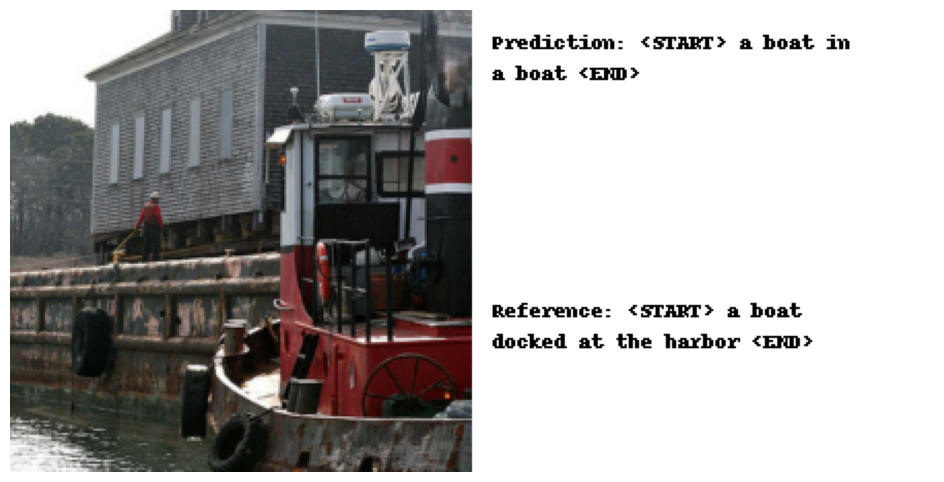

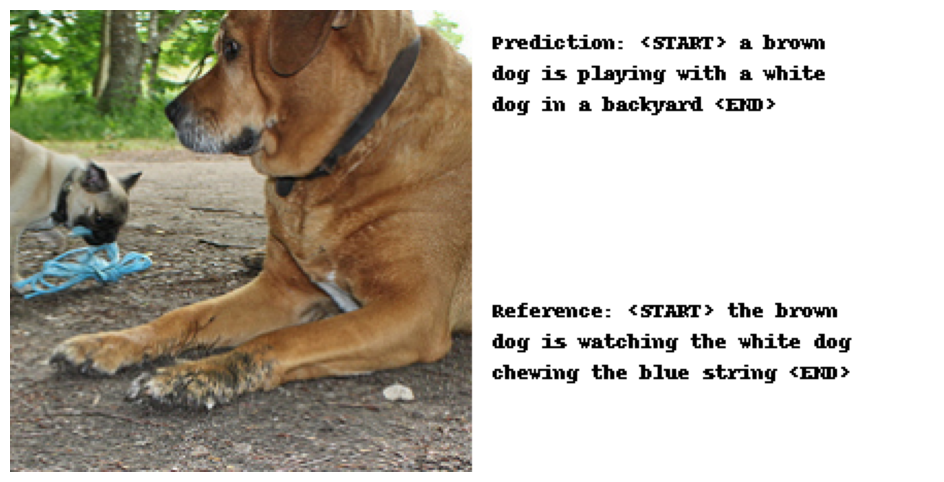

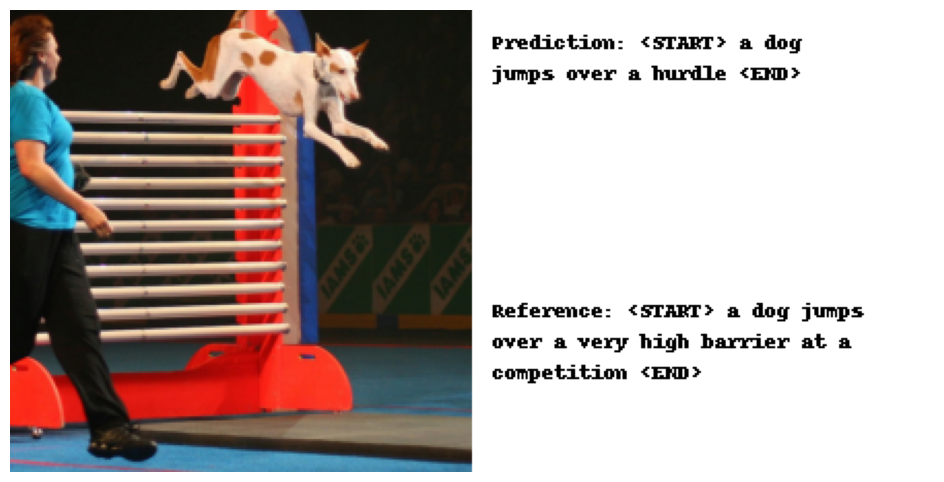

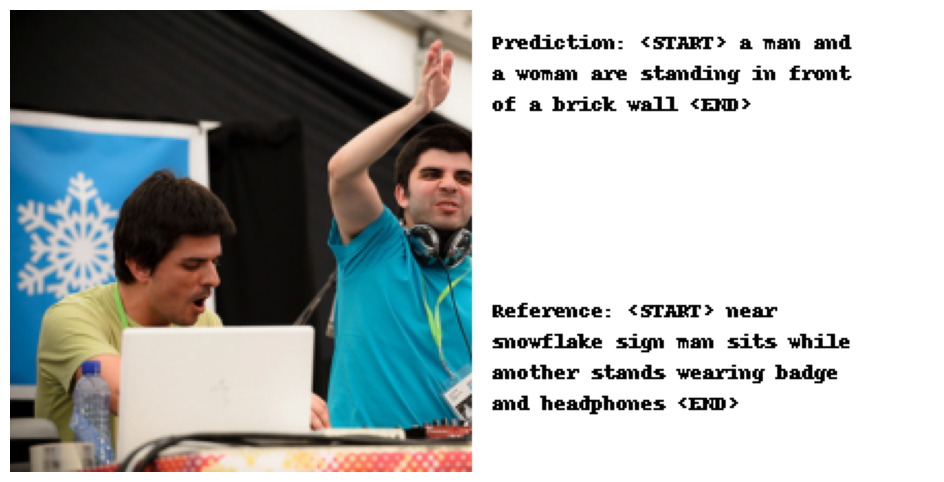

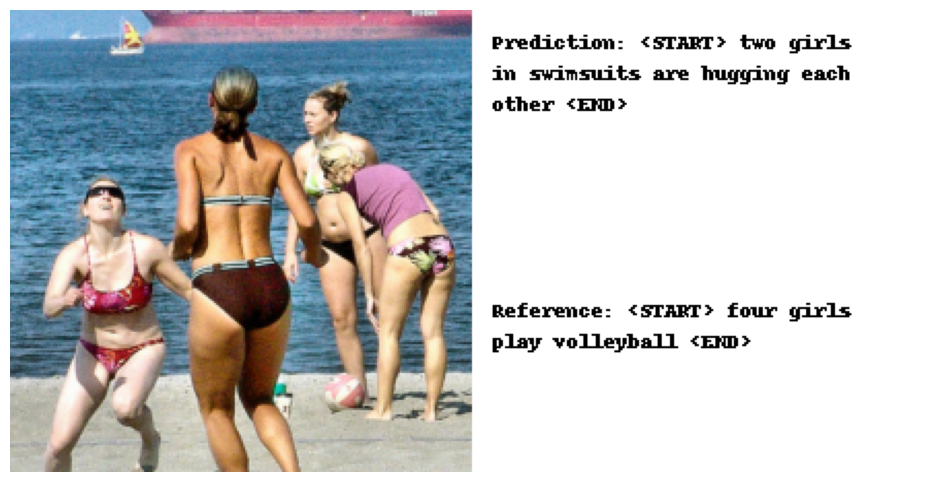

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Normalize
from PIL import Image, ImageDraw, ImageFont
import textwrap

# Define the denormalization transform
denormalize = Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def display_results(data_loader, encoder, decoder, device, num_samples=5):
    encoder.eval()
    decoder.eval()

    # Get a batch from the DataLoader
    batch = next(iter(data_loader))

    # Extract images and captions from the batch
    images = batch['image']
    captions = batch['caption']

    # Use only the first `num_samples` images
    num_samples = min(num_samples, len(images))
    images = images[:num_samples]

    for i in range(num_samples):
        image = images[i]

        # Inference using the normalized image
        caption = infer(encoder, decoder, image, device)

        # Denormalize and convert image tensor to PIL image for visualization
        denormalized_image = denormalize(image)
        to_pil = ToPILImage()
        image_pil = to_pil(denormalized_image)

        # Create a white image for the text background
        text_image = Image.new("RGB", (image_pil.width, image_pil.height), "white")
        draw = ImageDraw.Draw(text_image)

        # Use a basic font, or specify the path to a .ttf file
        font = ImageFont.load_default()

        # Prepare the text to be displayed, wrapping it to fit the width
        max_width = text_image.width - 10  # Leave some padding
        wrapper = textwrap.TextWrapper(width=int(max_width / 7))  # Adjust width factor as needed

        prediction_text = "Prediction:\n" + ' '.join(caption)
        wrapped_prediction = wrapper.fill(text=prediction_text)

        reference = [word for token in captions[i] for (word, token_v) in dataset.vocab.items() if token == token_v]
        reference = [token for token in reference if token != '<PAD>']
        reference_text = "Reference:\n" + " ".join(reference)
        wrapped_reference = wrapper.fill(text=reference_text)

        # Write the text on the white image
        draw.text((10, 10), wrapped_prediction, fill="black", font=font)
        draw.text((10, 140), wrapped_reference, fill="black", font=font)

        # Concatenate the image and the text side by side
        combined_image = Image.new('RGB', (image_pil.width * 2, image_pil.height))
        combined_image.paste(image_pil, (0, 0))
        combined_image.paste(text_image, (image_pil.width, 0))

        # Display the combined image
        plt.figure(figsize=(12, 6))
        plt.imshow(combined_image)
        plt.axis('off')
        plt.show()

# Example usage
display_results(train_loader, encoder, decoder, device)


# Discussão Geral

Após o treinamento, esses foram os resultados obtidos pelo modelo:

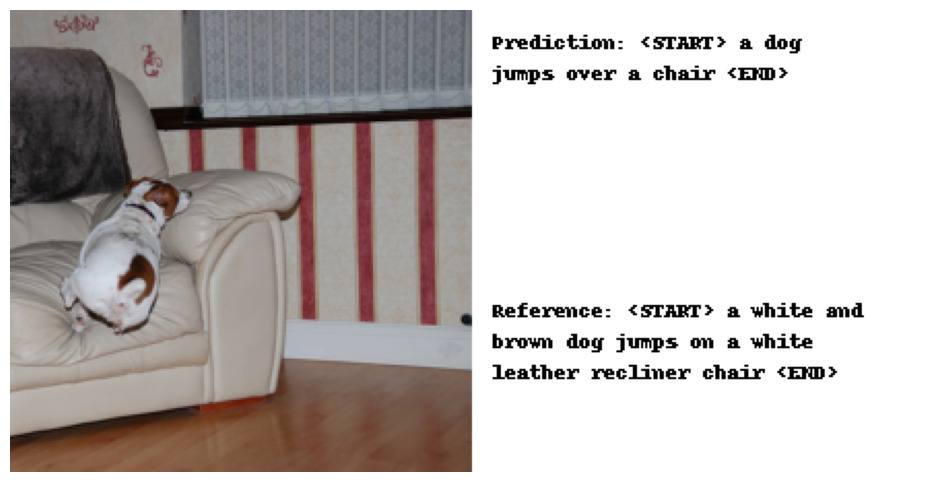

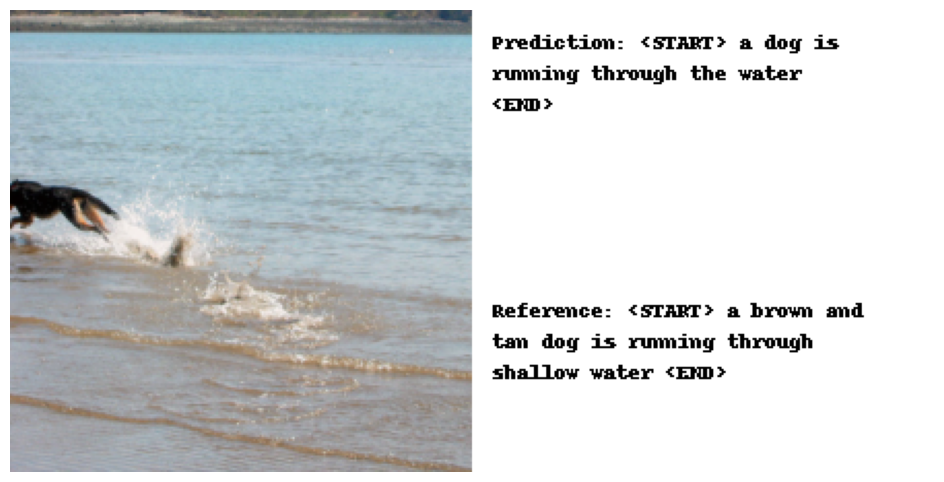

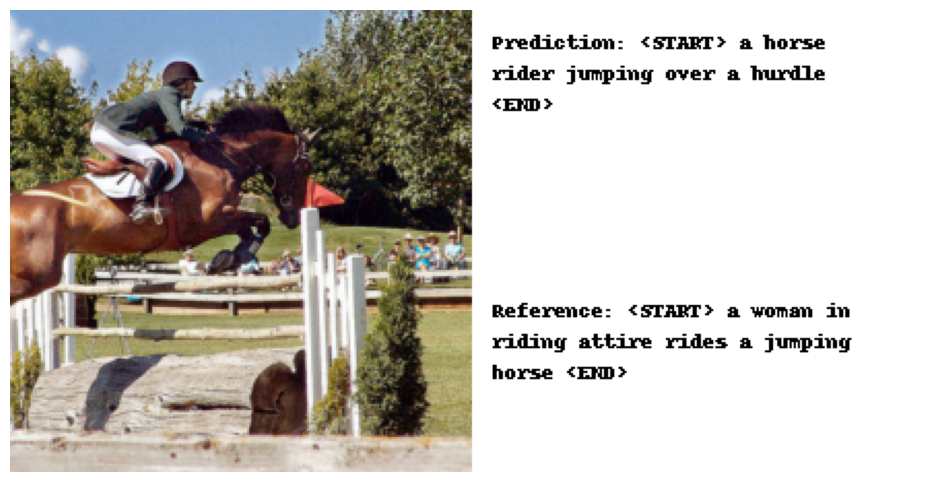

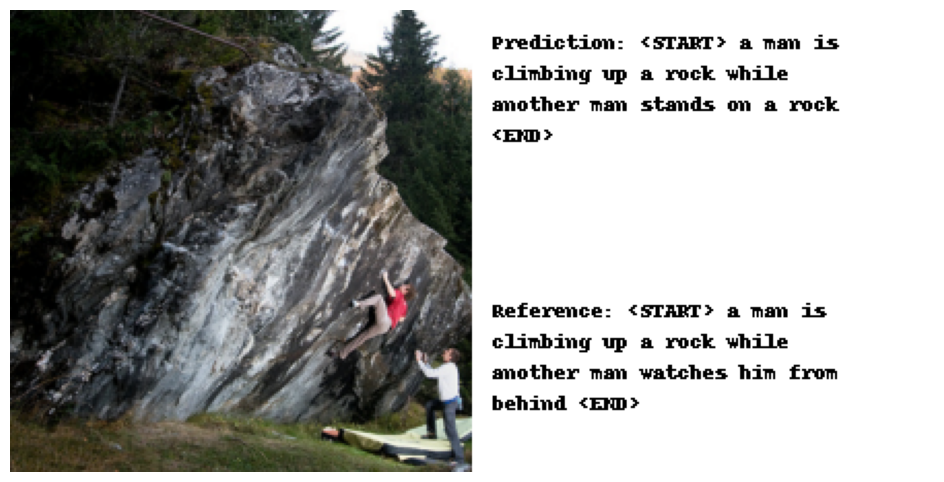

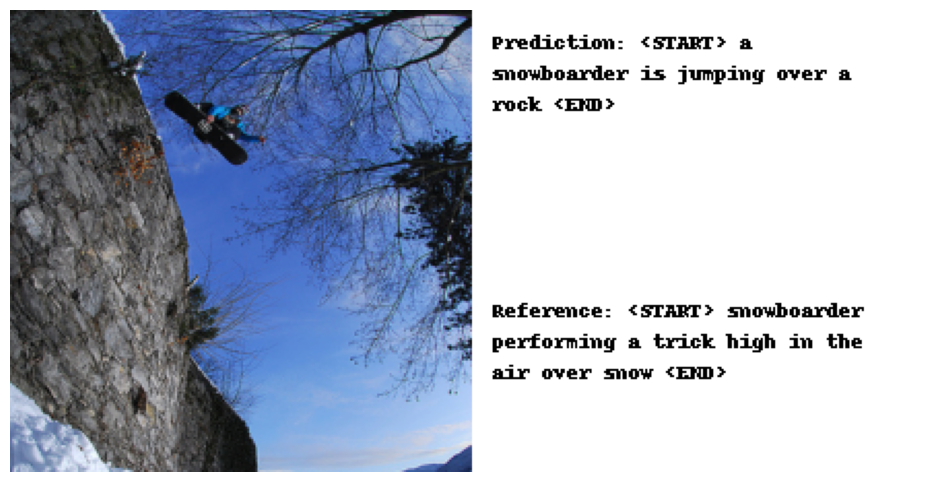

In [ ]:
display_results(train_loader, encoder, decoder, device)

No fim, o BLEU score ficou em 0.087 com uma acurácia média de 0.35

Um valor de 0.087 sugere que o texto gerado tem uma similaridade muito baixa com o texto de referência, o que pode significar que o modelo não conseguiu capturar bem o conteúdo, a estrutura, ou ambos, da sequência de referência. A acurácia, por sua vez, se refere ao quanto o modelo acertou exatamente o token e sua posição na frase. Desse modo, frases redigidas de maneira diferente, que apresentassem a mesma ideia ou conteúdo, ainda assim poderiam ter acurácia relativamente baixa.

Por exemplo, quando o modelo prevê: "A snowboarder is jumping over a rock" e seu ground truth é "snowboarder performing a trick high in the air over snow", o modelo não se mostrou distante da realidade apontada pela frase de referência. Porém, quando o modelo prevê "a boat in a boat" e seu ground truth é "a boat docked in the harbor", a previsão se mostra bastante confusa e distante da realidade.

Contudo, observando os exempolos, o modelo tem demonstrado uma capacidade eficiente de identificar e classificar um  sujeitos e objeto presentes nas imagens, reconhecendo com precisão relativamente alta elementos como pessoas, animais, objetos, e seus respectivos papéis na cena.
No entanto, quando se trata de compreender e categorizar as ações realizadas por esses indivíduos, o desempenho do modelo é menos preciso. Isso pode se manifestar na dificuldade em distinguir entre ações semelhantes ou em interpretar contextos complexos onde a ação depende de múltiplos fatores visuais ou temporais.

Essa limitação destaca a necessidade de aprimorar a capacidade do modelo em entender a dinâmica das interações entre sujeitos e objetos, além de considerar melhor o contexto em que as ações ocorrem para alcançar uma interpretação mais precisa e contextualizada.

Possíveis formas de melhorar a identificação das ações desses indivíduos podem incluir:
*  o fine tuning da EfficientNet utilizada, já que, nessa implementação foi utilizado o modelo com parâmetros pré-treinados
* o uso de datasets que apresentem mais dados e uma grande variedade de ações, juntamente com anotações detalhadas

Além disso, vale pontuar que encontrar os melhores hiperparametros para as redes, tanto o encoder quanto o encoder, é um trabalho que potencialmente melhorariam os resultados.

